# Atelier: Prédiction floue du risque de panne d'une machine industrielle

DOULFAQAR Abdellah

In [46]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

## Entrées
### Température

In [47]:
Température = ctrl.Antecedent(np.arange(0, 100, 1), 'Température')
Température['Basse'] = fuzz.trimf(Température.universe, [0, 0, 40])
Température['Normale'] = fuzz.trimf(Température.universe, [30, 50, 70])
Température['Elevée'] = fuzz.trimf(Température.universe, [60, 100, 100])


c:\Users\abdel\AppData\Local\Programs\Python\Python312\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


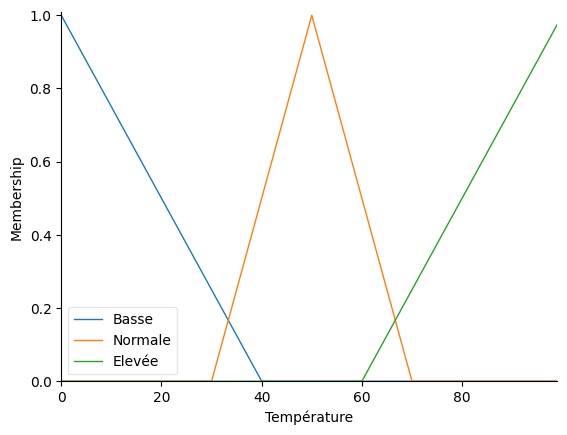

In [48]:
Température.view()

### Vibration

In [49]:
Vibration = ctrl.Antecedent(np.arange(0, 10, 1), 'Vibration')
Vibration['Faible'] = fuzz.trimf(Vibration.universe, [0, 0, 4])
Vibration['Moyenne'] = fuzz.trimf(Vibration.universe, [2, 5, 8])
Vibration['Forte'] = fuzz.trimf(Vibration.universe, [6, 10, 10])

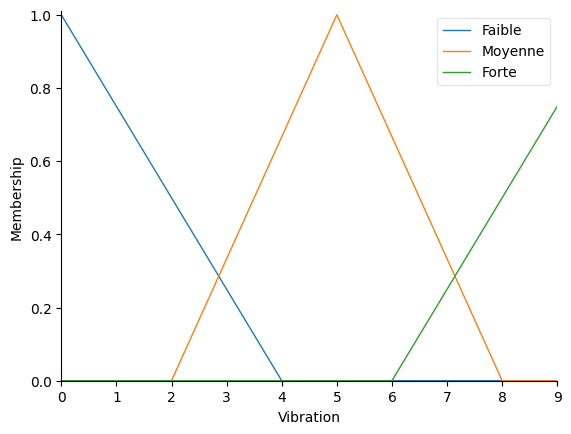

In [50]:
Vibration.view()

### Age

In [51]:
Age = ctrl.Antecedent(np.arange(0, 20, 1), 'Age')
Age['Neuf'] = fuzz.trimf(Age.universe, [0, 0, 7])
Age['Moyen'] = fuzz.trimf(Age.universe, [5, 10, 15])
Age['Ancien'] = fuzz.trimf(Age.universe, [12, 20, 20])

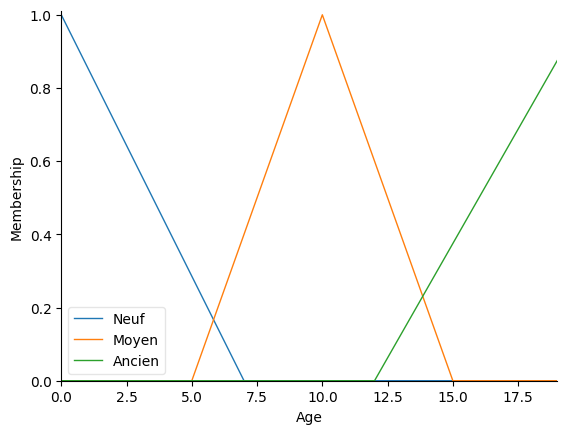

In [52]:
Age.view()

## Sortie
### Risque de panne

In [53]:
Risque_de_panne = ctrl.Consequent(np.arange(0, 10, 1), 'Risque_de_panne')
Risque_de_panne['Faible'] = fuzz.trimf(Risque_de_panne.universe, [0, 0, 4])
Risque_de_panne['Moyen'] = fuzz.trimf(Risque_de_panne.universe, [2, 5, 8])
Risque_de_panne['Elevé'] = fuzz.trimf(Risque_de_panne.universe, [6, 10, 10])

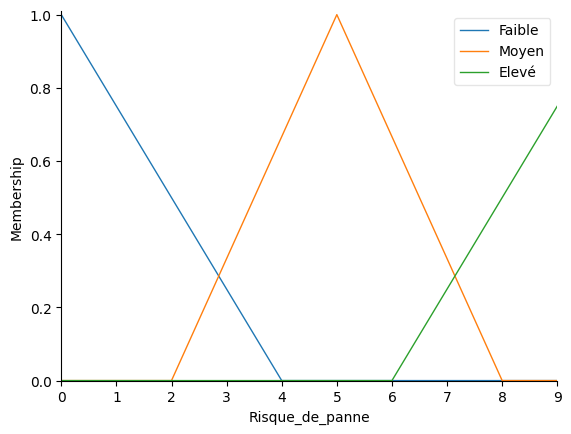

In [54]:
Risque_de_panne.view()

## Formulation des règles

In [55]:
rule1 = ctrl.Rule(Température['Elevée'] | Vibration['Forte'], Risque_de_panne['Elevé'])
rule2 = ctrl.Rule(Age['Ancien'] & Vibration['Moyenne'], Risque_de_panne['Moyen'])
rule3 = ctrl.Rule(Température['Basse'] & Vibration['Faible'] & Age['Neuf'], Risque_de_panne['Faible'])
rule4 = ctrl.Rule(Température['Normale'] & Age['Moyen'], Risque_de_panne['Moyen'])

In [56]:
system_control = ctrl.ControlSystem([rule1, rule2, rule3, rule4,])
system_simulation= ctrl.ControlSystemSimulation(system_control)
system_simulation.input['Température'] = 80
system_simulation.input['Vibration'] = 5.5
system_simulation.input['Age'] = 10
system_simulation.compute()
print(system_simulation.output['Risque_de_panne'])

7.916666666666666


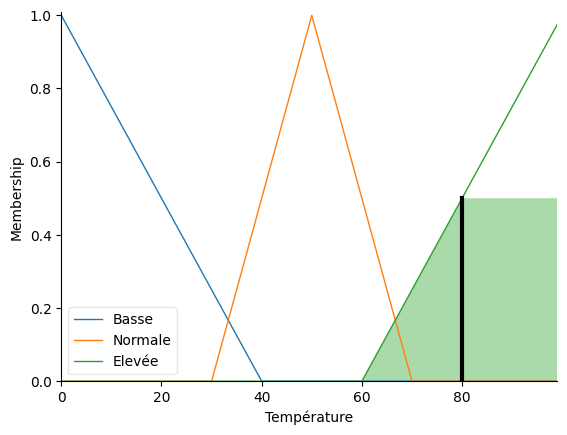

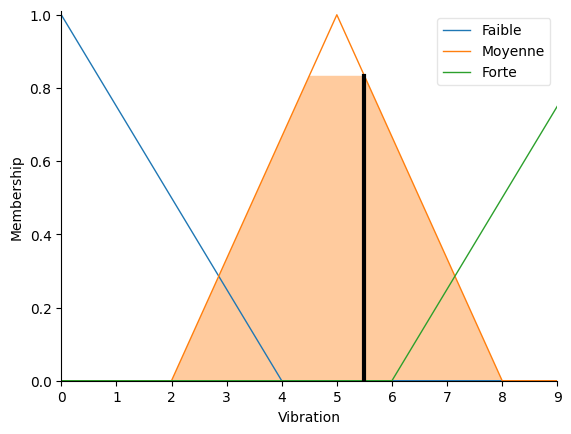

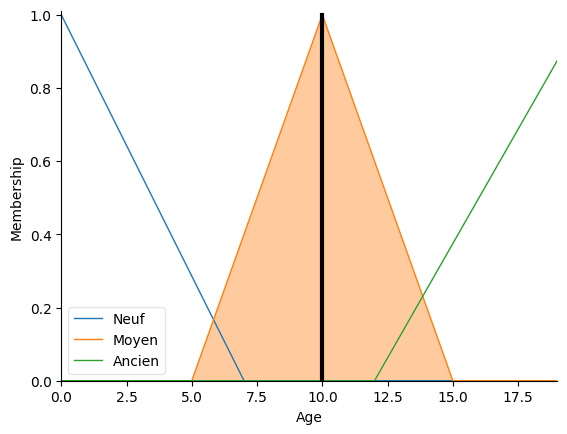

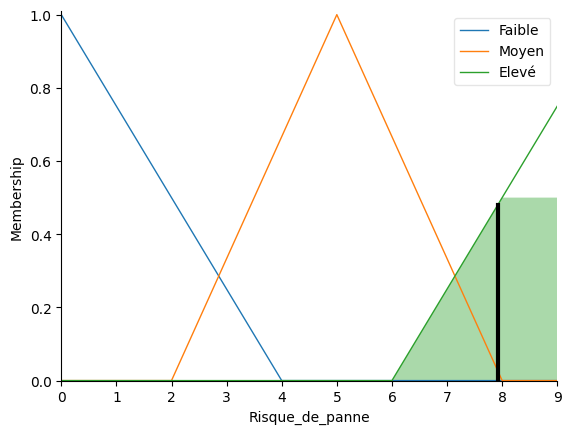

In [57]:
Température.view(sim=system_simulation)
Vibration.view(sim=system_simulation)
Age.view(sim=system_simulation)
Risque_de_panne.view(sim=system_simulation)


# Machine Learning

In [58]:
np.random.seed(42)
n_samples = 2000
temp_samples = np.random.uniform(0, 100, n_samples)
vib_samples = np.random.uniform(0, 10, n_samples)
age_samples = np.random.uniform(0, 20, n_samples)

risque_outputs = []
for t, v, a in zip(temp_samples, vib_samples, age_samples):
    system_simulation.input['Température'] = float(t)
    system_simulation.input['Vibration'] = float(v)
    system_simulation.input['Age'] = float(a)
    system_simulation.compute()
    try:
        val = float(system_simulation.output['Risque_de_panne'])
        if not np.isfinite(val):
            raise ValueError
    except Exception:
        val = float(np.nanmedian(risque_outputs)) if risque_outputs else 5.0
    risque_outputs.append(val)

df = pd.DataFrame({
    'Température': temp_samples,
    'Vibration': vib_samples,
    'Age': age_samples,
    'Risque de panne': risque_outputs
})

print(df.shape)
df.head()

(2000, 4)


,Température,Vibration,Age,Risque de panne
0,37.454012,2.617057,11.439918,5.000000
1,95.071431,2.469788,16.108647,6.649621
2,73.199394,9.062546,15.203219,8.000000
3,59.865848,2.495462,3.077998,6.649621
4,15.601864,2.719497,2.984989,1.700209


## ***Remarque***

Lors du calcul de la valeur défuzzifiée du risque de panne pour chaque ensemble de données à partir du modèle flou, j’ai constaté que, dans certains cas, aucune valeur n’était générée. Cela se produit lorsque les données d’entrée ne correspondent à aucune combinaison couverte par les règles définies. Par exemple, pour une **température normale**, une **vibration moyenne** et un **âge neuf**, aucune règle n’est activée, ce qui empêche le modèle de produire un risque défuzzifié.

Pour pallier ce problème et garantir un résultat pour chaque observation, j’ai choisi d’attribuer une valeur par défaut au risque lorsque le système ne renvoie rien. J’ai ainsi retenu la moyenne de l’intervalle de la variable de sortie, soit 
***(10+0)/2=5***, correspondant à un niveau de risque moyen.

In [59]:
X = df[['Température', 'Vibration', 'Age']].values
y = df['Risque de panne'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

MAE: 0.06098696891340047
MSE: 0.027318709434041074


In [60]:
df_results = pd.DataFrame(X_test, columns=['Température', 'Vibration', 'Age'])
df_results['Risque de panne_LF'] = y_test
df_results['Risque de panne_pred'] = y_pred
df_results['abs_error'] = np.abs(df_results['Risque de panne_LF'] - df_results['Risque de panne_pred'])

print(df_results.shape)
df_results.head()

(400, 6)


,Température,Vibration,Age,Risque de panne_LF,Risque de panne_pred,abs_error
0,77.644745,8.146710,9.107898,7.937015,7.943477,0.006462
1,16.293443,8.736986,19.158917,7.992933,7.977631,0.015303
2,99.633392,1.949752,6.064396,8.000000,7.999989,0.000011
3,89.267171,0.546344,3.233891,7.999418,7.999221,0.000197
4,7.857850,2.034727,14.409135,5.000000,5.377662,0.377662


### Comparaison entre model et logique floue

In [61]:
example = {'Température': 80, 'Vibration': 7.5, 'Age': 7}

t = float(example['Température'])
v = float(example['Vibration'])
a = float(example['Age'])

In [62]:
system_simulation.input['Température'] = float(t)
system_simulation.input['Vibration'] = float(v)
system_simulation.input['Age'] = float(a)
system_simulation.compute()
risque_fuzzy = float(system_simulation.output['Risque_de_panne'])

In [63]:
risque_model = float(model.predict(np.array([[t, v, a]]))[0])

In [64]:
print(f"Input -> Température: {t} | Vibration: {v} | Age: {a}")
print(f"Logique floue Risque_de_panne: {risque_fuzzy:.6f}")
print(f"Risque_de_panne (prédiction): {risque_model:.6f}")
print(f"Erreur absolue: {abs(risque_fuzzy - risque_model):.6f}")

Input -> Température: 80.0 | Vibration: 7.5 | Age: 7.0
Logique floue Risque_de_panne: 7.916667
Risque_de_panne (prédiction): 7.920013
Erreur absolue: 0.003347


# Conclusion

- Le modèle ML approxime bien mais avec des erreur sur les données simulées.
- Logique floue : explicable, contrôlable via règles, fiable pour systèmes critiques et comportement attendu.